In [1]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os

import logging
logging.getLogger().setLevel(logging.INFO)

from alphabase.spectral_library.flat import SpecLibFlat
from alphabase.spectral_library.base import SpecLibBase
from alphabase.spectral_library.reader import LibraryReaderBase
from tqdm import tqdm
from alphabase.peptide.precursor import get_mod_seq_formula
from alphabase.constants.isotope import IsotopeDistribution
from alphadia.extraction.utils import reannotate_fragments
from alphabase.psm_reader import psm_reader_provider

INFO:root:


In [2]:
import warnings 

def fragment_number(precursor_df, fragment_intensity_df) :
    if not set(['frag_start_idx', 'frag_stop_idx']).issubset(precursor_df.columns):
        warnings.warn('frag_start_idx and frag_stop_idx not in dataframe')
        return
    
    n_fragments = []
    
    for start, stop in zip(precursor_df['frag_start_idx'].values, precursor_df['frag_stop_idx'].values):
        n_fragments += [np.sum(fragment_intensity_df.iloc[start:stop].values > 0)]

    precursor_df['n_fragments'] = n_fragments

def calc_isotope_dist(precursor_df, max_isotope = 6, min_intensity = 0.001):
    isotope_dist = IsotopeDistribution()

    col_names = ['i_{}'.format(i) for i in range(max_isotope)]
    precursor_df[col_names] = 0.

    for i in tqdm(range(len(precursor_df))):

        row = precursor_df.iloc[i]
        dist, mono = isotope_dist.calc_formula_distribution(
            get_mod_seq_formula(row['sequence'], row['mods'])
        )
        dist[dist < 0.001] = 0.
        dist = dist / dist.sum()
        precursor_df.loc[i, col_names] = dist[:max_isotope]

In [3]:
lib_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/marvin_scp/MSfragger_library_mod_noLossType.tsv'
#insilico_lib_location = '/Users/georgwallmann/Documents/data/libraries/2022_111_brunner_2022_1ng_all_29_human_trypsin_diann_decoy.hdf'
output_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/marvin_scp/MSfragger_library_mod_noLossType_d0_d4_d8_d12_shared_eg_n_fragments.hdf'

In [4]:
# create dense library from diann psm file
target_lib = LibraryReaderBase()
target_lib.add_modification_mapping(
    {'Oxidation@M':['M(Oxidation)'],
     'Dimethyl@K':['K(Dimethyl)'],
     'Dimethyl@R':['R(Dimethyl)'],
     'Dimethyl@Any N-term':['(Dimethyl)']
    }
)
psm = target_lib.import_file(lib_location)

In [5]:
target_lib.fragment_mz_df

,b_z1,b_z2,y_z1,y_z2,b_modloss_z1,b_modloss_z2,y_modloss_z1,y_modloss_z2
0,176.106991,88.557133,628.377686,314.692481,0.0,0.0,0.0,0.0
1,263.139019,132.073148,541.345658,271.176467,0.0,0.0,0.0,0.0
2,360.191783,180.599530,444.292894,222.650085,0.0,0.0,0.0,0.0
3,459.260197,230.133737,345.224480,173.115878,0.0,0.0,0.0,0.0
4,572.344261,286.675769,232.140416,116.573846,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
554114,945.415982,473.211629,608.340238,304.673757,0.0,0.0,0.0,0.0
554115,1092.484396,546.745836,461.271824,231.139550,0.0,0.0,0.0,0.0
554116,1220.542973,610.775125,333.213246,167.110261,0.0,0.0,0.0,0.0
554117,1277.564437,639.285857,276.191783,138.599530,0.0,0.0,0.0,0.0


In [6]:

target_lib.precursor_df['decoy'] = 0
target_lib._precursor_df['channel'] = 0
target_lib._fragment_mz_df = target_lib._fragment_mz_df[['b_z1', 'b_z2', 'y_z1', 'y_z2']]
target_lib._fragment_intensity_df = target_lib._fragment_intensity_df[['b_z1', 'b_z2', 'y_z1', 'y_z2']]
fragment_number(target_lib.precursor_df, target_lib._fragment_intensity_df)
target_lib._precursor_df['elution_group_idx'] = np.arange(len(target_lib._precursor_df))

In [7]:
calc_isotope_dist(target_lib.precursor_df)

100%|██████████| 45867/45867 [00:17<00:00, 2694.94it/s]


In [8]:
from alphabase.constants import modification

modification.add_new_modifications(
    {
        "Dimethyl:d12@Protein N-term": {
        "composition":"H(-2)2H(8)13C(2)"
        },
        "Dimethyl:d12@Any N-term": {
        "composition":"H(-2)2H(8)13C(2)",
        },
        "Dimethyl:d12@R": {
        "composition":"H(-2)2H(8)13C(2)",
        },
        "Dimethyl:d12@K": {
        "composition":"H(-2)2H(8)13C(2)",
        },
    }
)

In [9]:
from alphabase.peptide import fragment

channel_lib_list = []
for channel, original_mod, new_mod in [
    (4, 'Dimethyl@', 'Dimethyl:2H(4)@'),
    (8, 'Dimethyl@', 'Dimethyl:2H(6)13C(2)@'),
    (12, 'Dimethyl@', 'Dimethyl:d12@')
    ]:

    channel_lib = target_lib.copy()

    channel_lib._precursor_df['mods'] = channel_lib._precursor_df['mods'].str.replace(original_mod, new_mod)
    channel_lib._precursor_df['channel'] = channel
    fragment.update_precursor_mz(channel_lib._precursor_df)
    channel_lib.calc_fragment_mz_df()
    channel_lib_list += [channel_lib]
    channel_lib.precursor_df.head()


In [10]:
for lib in channel_lib_list:
    target_lib.append(lib)

/Users/georgwallmann/Documents/git/alphabase/alphabase/spectral_library/base.py:190: UserWarning: Unmatched columns in second dataframe will be dropped: {'y_modloss_z1', 'b_modloss_z2', 'b_modloss_z1', 'y_modloss_z2'}.
  warnings.warn(
/Users/georgwallmann/Documents/git/alphabase/alphabase/spectral_library/base.py:190: UserWarning: Unmatched columns in second dataframe will be dropped: {'y_modloss_z1', 'b_modloss_z2', 'b_modloss_z1', 'y_modloss_z2'}.
  warnings.warn(
/Users/georgwallmann/Documents/git/alphabase/alphabase/spectral_library/base.py:190: UserWarning: Unmatched columns in second dataframe will be dropped: {'y_modloss_z1', 'b_modloss_z2', 'b_modloss_z1', 'y_modloss_z2'}.
  warnings.warn(


In [11]:
target_lib.precursor_df.sort_values('elution_group_idx', inplace=True)
target_lib.remove_unused_fragments()

In [12]:
target_lib.precursor_df.sort_values('elution_group_idx', inplace=True)
target_lib.precursor_df

,genes,mobility,precursor_mz,mods,charge,proteins,mod_sites,rt,nAA,sequence,...,decoy,channel,n_fragments,elution_group_idx,i_0,i_1,i_2,i_3,i_4,i_5
0,AAAS,0.770291,402.242340,Dimethyl@Any N-term,2,Q9NRG9,0,41.360470,7,FSPVLGR,...,0,0,8,0,0.624179,0.285548,0.074148,0.014007,0.002118,0.000000
45867,AAAS,0.770291,404.254892,Dimethyl:2H(4)@Any N-term,2,Q9NRG9,0,41.360470,7,FSPVLGR,...,0,4,8,0,0.624179,0.285548,0.074148,0.014007,0.002118,0.000000
137601,AAAS,0.770291,408.278625,Dimethyl:d12@Any N-term,2,Q9NRG9,0,41.360470,7,FSPVLGR,...,0,12,8,0,0.624179,0.285548,0.074148,0.014007,0.002118,0.000000
91734,AAAS,0.770291,406.264523,Dimethyl:2H(6)13C(2)@Any N-term,2,Q9NRG9,0,41.360470,7,FSPVLGR,...,0,8,8,0,0.624179,0.285548,0.074148,0.014007,0.002118,0.000000
137602,AAAS,0.812664,489.017799,Dimethyl:d12@Any N-term;Dimethyl:d12@K,3,Q9NRG9,0;5,69.329221,12,VQDGKPVILLFR,...,0,12,19,1,0.425945,0.352398,0.157136,0.049609,0.012347,0.002565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45865,ZYX,1.140742,888.482549,Dimethyl@Any N-term;Dimethyl@K,2,Q15942,0;17,61.255183,17,VSSGYVPPPVATPFSSK,...,0,0,22,45865,0.353573,0.352783,0.190928,0.073438,0.022337,0.005686
91733,ZZZ3,1.041231,780.903217,Dimethyl:2H(4)@Any N-term;Dimethyl:2H(4)@K,2,Q8IYH5-2,0;14,25.497138,14,STVVDNDADFQGTK,...,0,4,15,45866,0.430039,0.342876,0.157073,0.052584,0.014183,0.003245
45866,ZZZ3,1.041231,776.878115,Dimethyl@Any N-term;Dimethyl@K,2,Q8IYH5-2,0;14,25.497138,14,STVVDNDADFQGTK,...,0,0,15,45866,0.430039,0.342876,0.157073,0.052584,0.014183,0.003245
137600,ZZZ3,1.041231,784.922480,Dimethyl:2H(6)13C(2)@Any N-term;Dimethyl:2H(6)...,2,Q8IYH5-2,0;14,25.497138,14,STVVDNDADFQGTK,...,0,8,15,45866,0.430039,0.342876,0.157073,0.052584,0.014183,0.003245


In [13]:
decoy_lib = target_lib.copy()

In [14]:
decoy_lib._precursor_df = decoy_lib._precursor_df[decoy_lib._precursor_df['channel'] == 0].copy()
decoy_lib.remove_unused_fragments()

In [15]:



#decoy_lib.import_file(brunner_lib)
decoy_lib.decoy = 'diann'
decoy_lib.append_decoy_sequence()
decoy_lib.precursor_df = decoy_lib.precursor_df[decoy_lib.precursor_df['decoy'] == 1]
fragment.update_precursor_mz(decoy_lib._precursor_df)
#decoy_lib.calc_precursor_mz()


,genes,mobility,precursor_mz,mods,charge,proteins,mod_sites,rt,nAA,sequence,...,decoy,channel,n_fragments,elution_group_idx,i_0,i_1,i_2,i_3,i_4,i_5
0,KIF2A,0.832315,442.781828,Dimethyl@Any N-term,2,O00139-2,0,60.353749,7,VLDLLQR,...,1,0,5,19644,0.592460,0.299762,0.086510,0.018197,0.003071,0.000000
1,DARS1,0.858842,438.252903,Dimethyl@Any N-term,2,P14868,0,46.637230,7,FVEPTVR,...,1,0,11,8375,0.588207,0.301891,0.088040,0.018684,0.003178,0.000000
2,SEC23B,0.796119,430.229625,Dimethyl@Any N-term,2,Q15437,0,16.943560,7,EEPTSLR,...,1,0,11,36025,0.617029,0.283169,0.080047,0.016860,0.002896,0.000000
3,PSMG2,0.806661,420.786913,Dimethyl@Any N-term,2,Q969U7-2,0,54.546727,7,LLALQVR,...,1,0,5,32010,0.614495,0.290787,0.077457,0.014955,0.002306,0.000000
4,H2BC12,0.815912,422.747985,Dimethyl@Any N-term,2,O60814,0,13.730023,7,EVQTALR,...,1,0,15,16124,0.630634,0.278102,0.074200,0.014698,0.002365,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45860,TPT1,1.250250,1222.079363,Dimethyl@Any N-term;Dimethyl@K,4,P13693,0;47,85.759439,47,TDGNIDDSLIGGNASAEGPEGEGTESTVITGVDIVMNHHLQETSFSK,...,1,0,17,41728,0.066500,0.167525,0.223949,0.209762,0.153781,0.093619
45861,TPT1,1.202068,981.063928,Dimethyl@Any N-term;Oxidation@M;Dimethyl@K,5,P13693,0;36;47,73.581703,47,TDGNIDDSLIGGNASAEGPEGEGTESTVITGVDIVMNHHLQETSFSK,...,1,0,31,41727,0.066341,0.167148,0.223611,0.209687,0.153950,0.093883
45862,TRMT1L,1.275914,1129.089165,Dimethyl@Any N-term;Dimethyl@K,4,Q7Z2T5,0;48,80.590339,48,DTAGVPAPAPDSALDSAPTPASAPAPAPALAQAPALSPSLASAPEELK,...,1,0,24,42088,0.082999,0.196205,0.242358,0.207442,0.137843,0.075598
45863,CDV3,1.120423,939.208835,Dimethyl@Any N-term;Dimethyl@K,4,Q9UKY7,0;49,13.505330,49,ALSAAGAAGSAGGSSGAAGAAGGGAGAGTRPGDGGTASAGAAGPGAASK,...,1,0,75,5788,0.141394,0.260841,0.256465,0.177225,0.096112,0.043393


In [16]:
from peptdeep.pretrained_models import ModelManager
from alphabase.peptide.fragment import get_charged_frag_types

model_mgr = ModelManager()

model_mgr.nce = 30
model_mgr.instrument = 'timsTOF'

In [17]:
decoy_lib.charged_frag_types = target_lib.charged_frag_types

In [18]:
res = model_mgr.predict_all(
    decoy_lib.precursor_df,
    predict_items=['ms2'],
    frag_types = decoy_lib.charged_frag_types,
)
#decoy_lib.calc_fragment_mz_df()

2023-04-20 13:26:32> Using multiprocessing with 8 processes ...
2023-04-20 13:26:33> Predicting ms2 ...


100%|██████████| 43/43 [00:11<00:00,  3.61it/s]


In [19]:
decoy_lib._precursor_df = res['precursor_df']
decoy_lib._fragment_mz_df = res['fragment_mz_df']
decoy_lib._fragment_intensity_df = res['fragment_intensity_df']

In [20]:
target_lib.append(decoy_lib)

/Users/georgwallmann/Documents/git/alphabase/alphabase/spectral_library/base.py:190: UserWarning: Unmatched columns in second dataframe will be dropped: {'instrument', 'nce'}.
  warnings.warn(
/Users/georgwallmann/Documents/git/alphabase/alphabase/spectral_library/base.py:190: UserWarning: Unmatched columns in second dataframe will be dropped: {'y_modloss_z1', 'b_modloss_z2', 'b_modloss_z1', 'y_modloss_z2'}.
  warnings.warn(


In [21]:
target_lib.precursor_df['n_fragments_allowed'] = target_lib.precursor_df['n_fragments']

In [32]:
fragment_number(target_lib.precursor_df, target_lib._fragment_intensity_df)

In [23]:
allowed = target_lib.precursor_df.groupby('elution_group_idx')[['n_fragments']].min().reset_index()

In [24]:
allowed

,elution_group_idx,n_fragments
0,0,6
1,1,15
2,2,16
3,3,14
4,4,13
...,...,...
45862,45862,15
45863,45863,20
45864,45864,22
45865,45865,13


In [25]:
target_lib.precursor_df.drop(columns=['n_fragments_allowed'], inplace=True)

In [26]:
target_lib.precursor_df = target_lib.precursor_df.merge(allowed, on='elution_group_idx', suffixes=['', '_allowed'])

In [27]:
target_lib.precursor_df[['n_fragments_allowed']]

,n_fragments_allowed
0,6
1,7
2,7
3,7
4,7
...,...
229328,32
229329,32
229330,32
229331,19


<AxesSubplot:xlabel='n_fragments', ylabel='Count'>

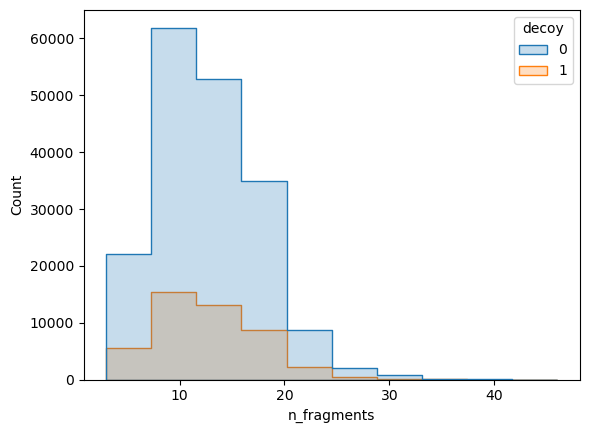

In [33]:
import seaborn as sns
sns.histplot(target_lib.precursor_df, x='n_fragments', hue='decoy', element='step', bins=10)

In [29]:
for i, (start_idx, stop_idx, k_allowed) in enumerate(
    zip(
        target_lib.precursor_df['frag_start_idx'].values, 
        target_lib.precursor_df['frag_stop_idx'].values, 
        target_lib.precursor_df['n_fragments_allowed'].values
        )
    ):
    intensies = target_lib._fragment_intensity_df.iloc[start_idx:stop_idx].values
    flat_intensities = np.sort(intensies.flatten())[::-1]
    target_lib._fragment_intensity_df.iloc[start_idx:stop_idx].values[intensies <= flat_intensities[k_allowed]] = 0

In [34]:
target_lib.precursor_df.drop(columns=['n_fragments'], inplace=True)

In [35]:
fragment_number(target_lib.precursor_df, target_lib._fragment_intensity_df)
target_lib.fragment_cardinality_df = fragment.calc_fragment_cardinality(target_lib.precursor_df, target_lib._fragment_mz_df)

In [36]:
target_lib.save_hdf(output_location)